# Alessandro Pomponio - alessandro.pomponio2@studio.unibo.it

In [14]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Variables
file_name = 'exam_2021_01_15.csv'
separator = ','
random_state = 42

# Directives
%matplotlib inline
np.random.seed(random_state)


1. load the data and separate in X all the columns but the last
one, in y the last column, then produce a pairplot of X and
comment what you see (4pt)
2. find the best clustering scheme for X with a method of your
choice, plot the silhouhette index for an appropriate range of
parameters and show the chosen hyperparameter(s)
(4pt)
3. fit the clustering scheme store the cluster labels in y_km and
output the silhouette score (2pt)
4. use the labels in the last column of the input file as the “gold
standard” for the clustering and compare y_km and y; for an
effective comparison, each label in y_km must be remapped
to the best label in y; compute and apply this re-mapping (5pt)
5. produce the confusion matrix comparing y and y_km with
sklearn.metrics.confusion_matrix, (2pt)
6. consider possible pre-processing actions, repeat the fitting
and evaluate as before the result of the new fitting (8pt)

## 1. load the data and separate in X all the columns but the last one, in y the last column, then produce a pairplot of X and comment what you see (4pt)

In [2]:
# Load the data
df = pd.read_csv(file_name, sep = separator)
last_column = 'y'

# Separate in X all the columns but the last one
X = df.drop(last_column, axis = 1)

# Save the last column in y
y = df[last_column]

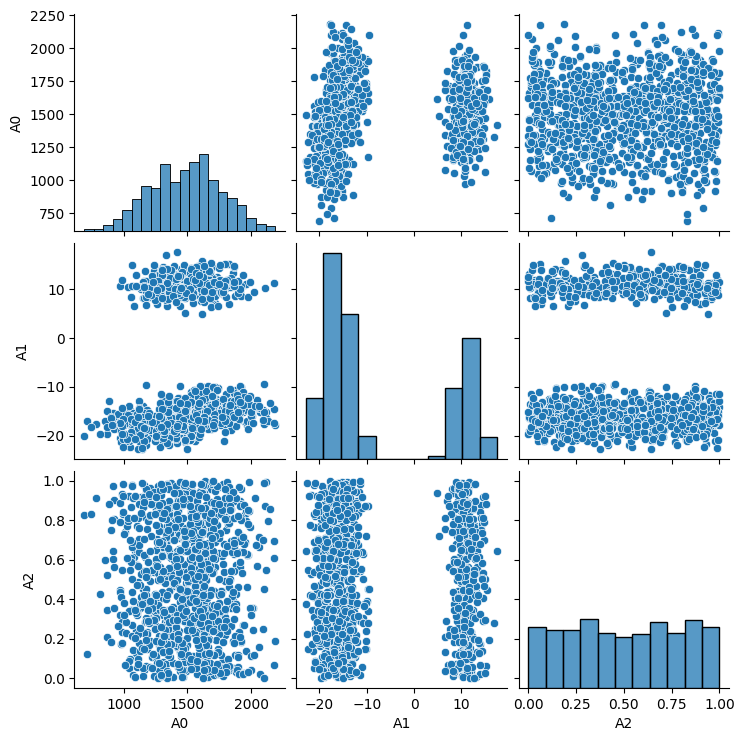

In [3]:
# Produce a pairplot of X and comment what you see
sns.pairplot(X)

It is clear how the column pairs (A1,A0) and (A2,A1) show perfect candidates for clustering, both with two well defined clusters

## 2. find the best clustering scheme for X with a method of your choice, plot the silhouhette index for an appropriate range of parameters and show the chosen hyperparameter(s) (4pt)
_consider carefully the number of clusters, simple optimisation of the silhouette will not be enough, decide visually the best number of clusters_

In order to find a clustering scheme, we will use K-means with the elbow method, ranging from 2 to 10 clusters

In [4]:
# Range of possible clusters
k_range = range(2,11)

# Silhouette Score as measure
silhouette_scores = []
distortions = []

for i in k_range:
    
    km = KMeans(n_clusters = i, 
                init = 'k-means++', 
                n_init = 10, 
                max_iter = 300, 
                random_state = random_state)

    y_km = km.fit_predict(X)
    silhouette_scores.append(silhouette_score(X,y_km))
    distortions.append(km.inertia_)

Plot silhouette scores

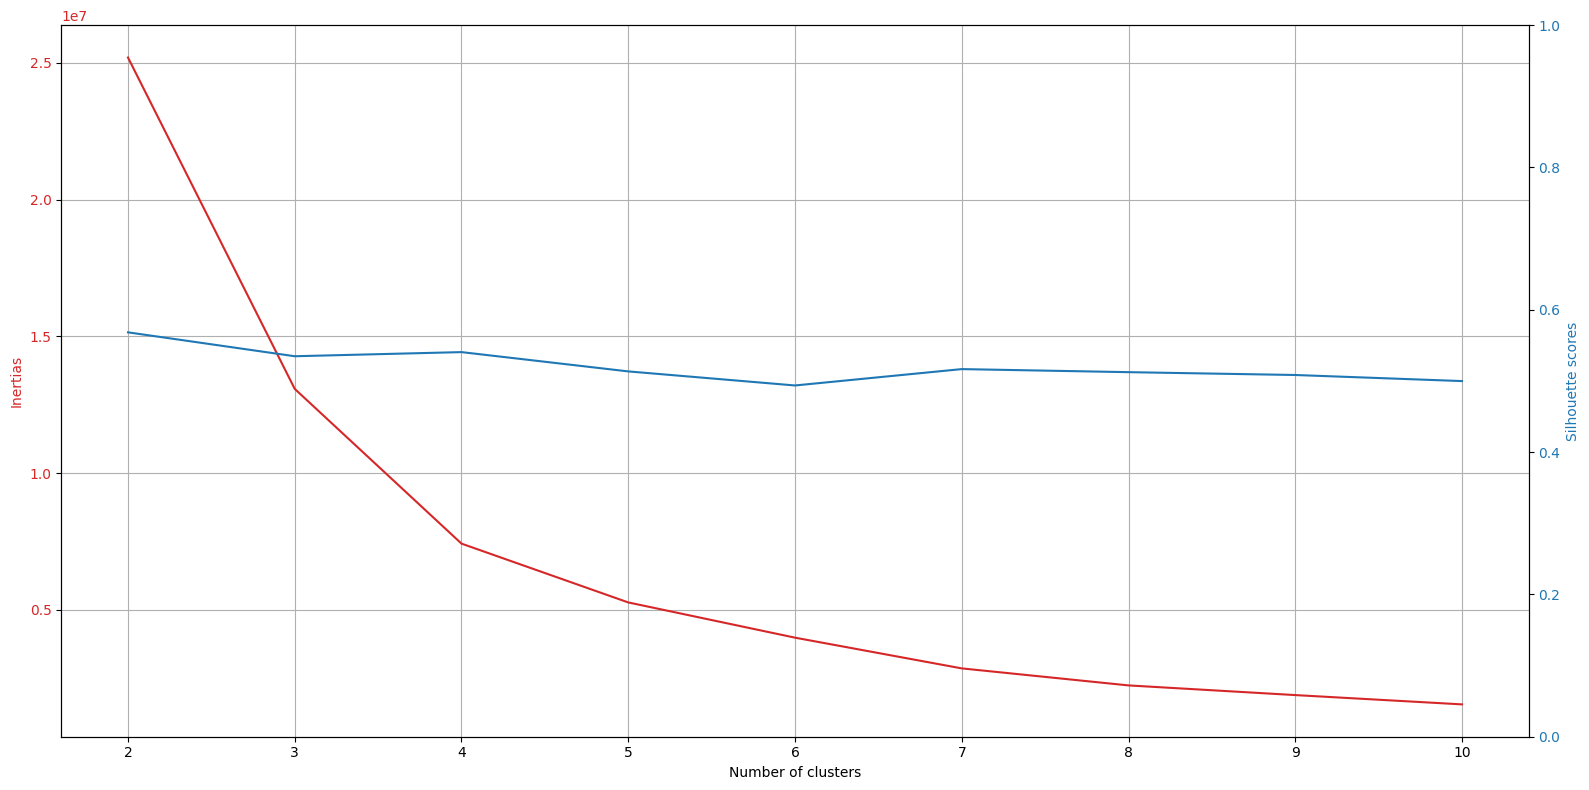

In [5]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):
    fig, ax1 = plt.subplots(figsize=(16,8))
    
    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1label, color=color)
    ax1.plot(x, y1, color=color)
    plt.grid()
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(y2label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

two_plots(x=k_range, y1=distortions, y2=silhouette_scores
          , xlabel='Number of clusters', y1label='Inertias', y2label='Silhouette scores'
         )

The silhouette scores tell us that the best hyperparameter is 2 clusters, just like we imagined.

The problem, though, is that by looking at the data we notice that there are three values of y. For this reason, we will decide to use `best_k = 3` instead of `best_k = 2`. With that said, if we plot the clusters along with their predicted labels, we can see how KMeans performed quite poorly in both instances.


In [6]:
best_k = 3

## 3. fit the clustering scheme store the cluster labels in y_km and output the silhouette score (2pt)

In [7]:
# Fit the clustering scheme, store the cluster labels in y_km
km = KMeans(n_clusters = best_k, 
            init = 'k-means++', 
            n_init = 10, 
            max_iter = 300,
            tol = 1e-04,
            random_state = random_state)

y_km = km.fit_predict(X)

# Output the silhouette score
print(f"The silhouette score for best_k = 3 was {silhouette_score(X,y_km)}")

The silhouette score for best_k = 3 was 0.5347177935458869


## 4. use the labels in the last column of the input file as the “gold standard” for the clustering and compare y_km and y; for an effective comparison, each label in y_km must be remapped to the best label in y; compute and apply this re-mapping (5pt)

_hint for each subset of the data with x in y_km find the most frequent label in y_

From what I've understood, we need to look at "subsets" in `y_km` (as in: "streaks" of labels) and then remap them to the most common label for that range in `y`

To do so, we will iterate over y_km and check if we're in a streak of labels, comparing the current label with the previous one, saving the first index of each streak.

Once the streak of labels ends, we will find out which is the most common label for that range in y and set it as the `gold_standard`, applying it to the values of `y_km` and recording how many changes have been performed

In [8]:
# For this algorithm to work correctly we need to have 
# a match in the first iteration
previous_label = y_km[0]
start_idx = 0
changes = 0

for idx, label in enumerate(y_km):

    # Apply remapping
    if label != previous_label:

        # Count the occurrences in the corresponding
        # y_km subset
        occurrences = np.bincount(y[start_idx:idx])

        # Find which cluster index is the most frequent
        gold_standard = np.argmax(occurrences)

        # Remap the clusters
        for i in range(start_idx, idx):
            
            if y_km[i] != gold_standard:
                y_km[i] = gold_standard
                changes = changes + 1
        
        # The current index will now be the new start idx
        start_idx = idx

    # Save current label as 'previous_label'
    previous_label = label

In [9]:
print(f"This remapping performed {changes} changes to y_km subsets")

This remapping performed 669 changes to y_km subsets


## 5. produce the confusion matrix comparing y and y_km with sklearn.metrics.confusion_matrix, (2pt)

In [10]:
cm = confusion_matrix(y, y_km)
cm

array([[313,  15,   6],
       [ 56, 267,  10],
       [ 29,  49, 255]])

## 6. consider possible pre-processing actions, repeat the fitting and evaluate as before the result of the new fitting (8pt)

From the confusion matrix above, we see that our clustering scheme tends to predict labels 0 and 1 a bit too much

We could try to apply a logarithmic transformation to the columns that don't have values lower than or equal to zero and see what changes

In [11]:
for column in X.columns:

    # We don't want to transform columns with values
    # Lower than or equal to zero
    if len(X[column]) != sum(np.greater(X[column], 0)):
        continue

    X[column] = np.log(X[column])

Apply clustering again

In [12]:
# Fit the clustering scheme, store the cluster labels in y_km
km = KMeans(n_clusters = best_k, 
            init = 'k-means++', 
            n_init = 10, 
            max_iter = 300,
            tol = 1e-04,
            random_state = random_state)

y_km = km.fit_predict(X)

# Output the silhouette score
print(f"The silhouette score for best_k = 3 was {silhouette_score(X,y_km)}")

The silhouette score for best_k = 3 was 0.6142206906622645


In [13]:
cm = confusion_matrix(y, y_km)
cm

array([[ 39,   0, 295],
       [  0, 333,   0],
       [256,   0,  77]])

As we can see, while there are still a lot of wrong labels, we now have less errors and we correctly predict all the instances of cluster 0.

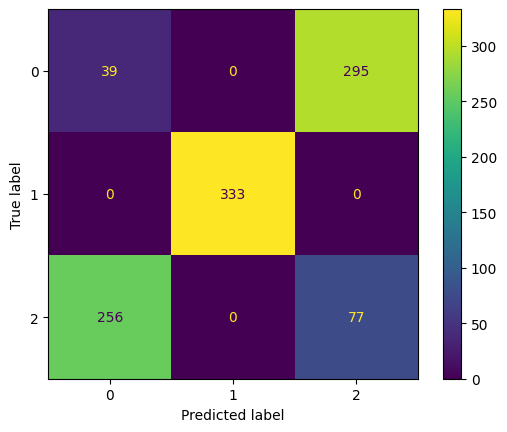

In [15]:
fig = ConfusionMatrixDisplay(cm)

fig.plot()